# **AI for Finance - Assignment 1**

**Francesco Trono (221723)**

*University of Trento - A.Y. 2021/2022*

francesco.trono@studenti.unitn.it

Click here to open & run in Google Colab environment:


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ftrono/AI_for_Finance/blob/main/Assignment_1/221723_Assignment_1.ipynb)

°  °  °

In this Assignment, I have performed an OLS Regression of a stock and a portfolio, using different source data, in order to calculate their performance compared to the market.

This *Jupyter* notebook contains the code split into separate cells, each visualizing also the output of each execution, in a linear and understandable format. 

**PART I** of the notebook contains all the data extraction and preparation operations, while **PART II** directly uses the prepared data to answer the Assignment questions.

#### **Libraries import:**

In [1]:
!pip3 install --upgrade pandas-datareader >/dev/null
#imports:
import os, statistics
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


---

## **PART I - Data preparation**

For the data preparation, the operations I performed can be summarized in the following way.


#### **Get risk free data (Rf):**

* First, I imported Fama & French monthly data, in order to get both the risk free (“rf”) and the market premium (“FF_(rm-rf)”) data for the 30 years starting February 1st, 1992:

In [2]:
#download risk free file from Fama&French website, extract csv and import it to Pandas:
zipname = 'F-F_Research_Data_Factors_CSV.zip'
csvname = r"F-F_Research_Data_Factors.CSV"
if os.path.exists(zipname) == False:
  !wget 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip' >/dev/null
  !unzip 'F-F_Research_Data_Factors_CSV.zip' >/dev/null

  #extract needed exhibit from csv file (there are two exhibits):
  with open(csvname, 'r+') as fp:
    #store read file:
    lines = fp.readlines()  

    #skip first three lines, then save index of the first empty line (at the end of the first exhibit):
    ind = 3
    for line in lines[3:-1]:
      ind += 1
      if line == '\n':
        print(ind)
        break

    #empty original file:
    fp.seek(0)
    fp.truncate()
    #rewrite only lines corresponding to the 1st exhibit:
    fp.writelines(lines[3:ind])

#import csv to Pandas:
Rf = pd.read_csv(csvname)
Rf.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
print(Rf)

--2022-03-19 11:35:44--  http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip
Resolving mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)... 129.170.171.144
Connecting to mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)|129.170.171.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12587 (12K) [application/x-zip-compressed]
Saving to: ‘F-F_Research_Data_Factors_CSV.zip’

F-F_Research_Data_F 100%[===================>]  12.29K  --.-KB/s    in 0s      

2022-03-19 11:35:44 (238 MB/s) - ‘F-F_Research_Data_Factors_CSV.zip’ saved [12587/12587]

1152
        Date  Mkt-RF   SMB    HML    RF
0     192607    2.96 -2.38  -2.73  0.22
1     192608    2.64 -1.47   4.14  0.25
2     192609    0.36 -1.39   0.12  0.23
3     192610   -3.24 -0.13   0.65  0.32
4     192611    2.53 -0.16  -0.38  0.31
...      ...     ...   ...    ...   ...
1142  202109   -4.37  0.80   5.09  0.00
1143  202110    6.65 -2.28  -0.44  0.00
1144  202111   -1.55 -1.35 

In [3]:
#slice needed portion of data (max = 30Y):
Rf_30 = Rf.loc[(Rf['Date'] >= 199202)]
Rf_30 = Rf_30.loc[(Rf_30['Date'] <= 202201)]
Rf_30.reset_index(drop=True, inplace=True)
print(Rf_30)

       Date  Mkt-RF   SMB    HML    RF
0    199202    1.09  0.87   6.47  0.28
1    199203   -2.66 -1.04   3.55  0.34
2    199204    1.07 -6.06   4.32  0.32
3    199205    0.30  0.41   1.19  0.28
4    199206   -2.34 -3.07   3.25  0.32
..      ...     ...   ...    ...   ...
355  202109   -4.37  0.80   5.09  0.00
356  202110    6.65 -2.28  -0.44  0.00
357  202111   -1.55 -1.35  -0.53  0.00
358  202112    3.10 -1.57   3.23  0.01
359  202201   -6.23 -5.88  12.78  0.00

[360 rows x 5 columns]


#### **Get Microsoft data (Rs):**

* Then, I extracted from Yahoo Finance the monthly prices for my chosen stock, Microsoft (ticker: “MSFT”), for the same 30-year period. For the analysis, I have only considered the column named “Adj close price”, in order to base the regression on a more flattened curve cleaned of the dividend effect:

In [4]:
#download MSFT data (max = 30Y):
Msft_30 = pdr.get_data_yahoo('MSFT', start='1992-02-01', end='2022-01-31', interval='m')
Msft_30.reset_index(inplace=True)
print(Msft_30[['Date', 'Close', 'Adj Close']])

          Date       Close   Adj Close
0   1992-02-01    2.572917    1.625809
1   1992-03-01    2.468750    1.559987
2   1992-04-01    2.296875    1.451380
3   1992-05-01    2.520833    1.592898
4   1992-06-01    2.187500    1.382266
..         ...         ...         ...
355 2021-09-01  281.920013  280.824524
356 2021-10-01  331.619995  330.331360
357 2021-11-01  330.589996  329.305389
358 2021-12-01  336.320007  335.626038
359 2022-01-01  310.980011  310.338318

[360 rows x 3 columns]


In [5]:
#convert MSFT prices to returns (use monthly pct_change):
ret_msft = Msft_30['Adj Close'].pct_change(1, fill_method ='ffill')
#replace NaN with zeroes:
ret_msft.fillna(0, inplace=True)
print(ret_msft.head())

0    0.000000
1   -0.040486
2   -0.069620
3    0.097506
4   -0.132232
Name: Adj Close, dtype: float64


#### **Get market data (S&P 500 Index, Rm):**

* Next, I extracted from Yahoo Finance the monthly prices for the S&P 500 index (market data), for the same 30-year period:

In [6]:
#download Market data (max = 30Y):
Mkt_30 = pdr.get_data_yahoo('^GSPC', start='1992-02-01', end='2022-01-31', interval='m')
Mkt_30.reset_index(inplace=True)
print(Mkt_30[['Date', 'Close', 'Adj Close']])

          Date        Close    Adj Close
0   1992-02-01   412.700012   412.700012
1   1992-03-01   403.690002   403.690002
2   1992-04-01   414.950012   414.950012
3   1992-05-01   415.350006   415.350006
4   1992-06-01   408.140015   408.140015
..         ...          ...          ...
355 2021-09-01  4307.540039  4307.540039
356 2021-10-01  4605.379883  4605.379883
357 2021-11-01  4567.000000  4567.000000
358 2021-12-01  4766.180176  4766.180176
359 2022-01-01  4515.549805  4515.549805

[360 rows x 3 columns]


In [7]:
#convert Market prices to returns (use monthly pct_change):
ret_mkt = Mkt_30['Adj Close'].pct_change(1, fill_method ='ffill')
#replace NaN with zeroes:
ret_mkt.fillna(0, inplace=True)
print(ret_mkt.head())

0    0.000000
1   -0.021832
2    0.027893
3    0.000964
4   -0.017359
Name: Adj Close, dtype: float64


#### **Get portfolio data (Rp):**

To build a diversified portfolio around MSFT, I chose 20 additional stocks from Yahoo Finance. 

I selected the stocks on the basis of specific diversification criteria:
* ***Industry diversification***: the stocks operate in different and potentially unrelated businesses;
* ***Geographic diversification***: the companies selected are incorporated in different countries, therefore ensuring a certain level of diversification of geographic risk (i.e. tax regulation). In particular, I chose 10 USA stocks and 10 non-USA stocks.

All the stocks selected have been actively traded in USA markets for more than 30 years.

Here follows an overview of the portfolio:



|	STOCK	|	TICKER	|	INDUSTRY	|	MARKET	|	COUNTRY	|
|	---------	|	---------	|	---------	|	---------	|	---------	|
|	*Microsoft*	|	***MSFT***	|	*tech*	|	*Nasdaq*	|	*USA*	|
|	Boeing	|	**BA**	|	aerospace	|	NYSE	|	USA	|
|	Southwest Airlines	|	**LUV**	|	airways	|	NYSE	|	USA	|
|	Ford Motors	|	**F**	|	automotive	|	NYSE	|	USA	|
|	Barclays	|	**BCS**	|	banking	|	NYSE	|	UK	|
|	Coca-Cola	|	**KO**	|	beverages	|	NYSE	|	USA	|
|	Walmart	|	**WMT**	|	consumer stores	|	NYSE	|	USA	|
|	Unilever	|	**UL**	|	consumer, household	|	NYSE	|	UK	|
|	Johnson & Johnson	|	**JNJ**	|	healthcare, pharma	|	NYSE	|	USA	|
|	Pfizer	|	**PFE**	|	healthcare, pharma	|	NYSE	|	USA	|
|	The Home Depot	|	**HD**	|	home improvement, stores	|	NYSE	|	USA	|
|	3M	|	**MMM**	|	industrial	|	NYSE	|	USA	|
|	Aegon N.V.	|	**AEG**	|	insurance	|	NYSE	|	Netherlands	|
|	JPMorgan Chase	|	**JPM**	|	investment banking	|	NYSE	|	USA	|
|	TotalEnergies SE	|	**TTE**	|	o&g	|	NYSE	|	France	|
|	Canadian Pacific Railway	|	**CP**	|	railroads	|	NYSE	|	Canada	|
|	Canon	|	**CAJ**	|	tech	|	NYSE	|	Japan	|
|	Sony	|	**SONY**	|	tech	|	NYSE	|	Japan	|
|	Ericsson	|	**ERIC**	|	tech communications	|	Nasdaq	|	Sweden	|
|	Vodafone	|	**VOD**	|	tlc	|	Nasdaq	|	UK	|
|	Telefónica	|	**TEF**	|	tlc	|	NYSE	|	Spain	|


.
* I finally extracted the portfolio data from Yahoo Finance following the same operations already defined for MSFT and S&P-500 index:

In [8]:
tickers = ['MSFT', 'BA', 'LUV', 'F', 'BCS', 'KO', 'WMT', 'UL', 'JNJ', 'PFE', 'HD', 'MMM', 'AEG', 'JPM', 'TTE', 'CP', 'CAJ', 'SONY', 'ERIC', 'VOD', 'TEF']

#download Portfolio data (max = 30Y):
MyPortfolio = pdr.get_data_yahoo(tickers, start='1992-02-01', end='2022-01-31', interval='m')
MyPortfolio.reset_index(inplace=True)
MyPortfolio = MyPortfolio[['Date', 'Adj Close']]
print(MyPortfolio.head())

Attributes       Date Adj Close                                           \
Symbols                    MSFT         BA       LUV         F       BCS   
0          1992-02-01  1.625809  12.904115  2.343875  2.040117  2.054785   
1          1992-03-01  1.559987  12.370324  2.240678  2.130327  1.725619   
2          1992-04-01  1.451380  12.405564  2.352342  2.518919  2.054304   
3          1992-05-01  1.592898  12.370324  2.568219  2.527457  2.282561   
4          1992-06-01  1.382266  11.306602  2.553332  2.612892  2.152500   

Attributes                                          ...                       \
Symbols           KO       WMT        UL       JNJ  ...        MMM       AEG   
0           5.016705  8.568610  4.016265  6.248077  ...   9.835169  1.041640   
1           5.016705  8.449598  3.765248  6.039351  ...   9.676136  1.049188   
2           5.111555  8.299171  3.955411  5.876752  ...  10.221264  1.045414   
3           5.419482  8.418302  4.094887  6.000639  ...  10.425693 

In [9]:
#convert portfolio assets' prices to returns (use monthly pct_change):
ret_mp = MyPortfolio['Adj Close'].pct_change(1, fill_method ='ffill')
#replace NaN with zeroes:
ret_mp.fillna(0, inplace=True)
print(ret_mp.head())

Symbols      MSFT        BA       LUV         F       BCS        KO       WMT  \
0        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1       -0.040486 -0.041366 -0.044028  0.044218 -0.160195  0.000000 -0.013889   
2       -0.069620  0.002849  0.049835  0.182410  0.190474  0.018907 -0.017803   
3        0.097506 -0.002841  0.091771  0.003389  0.111112  0.060241  0.014354   
4       -0.132232 -0.085990 -0.005797  0.033803 -0.056981 -0.090909  0.014151   

Symbols        UL       JNJ       PFE  ...       MMM       AEG       JPM  \
0        0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1       -0.062500 -0.033406 -0.062109  ... -0.016170  0.007246 -0.026022   
2        0.050505 -0.026923  0.028776  ...  0.056337 -0.003597  0.082257   
3        0.035262  0.021081  0.043706  ...  0.020000 -0.025271  0.039146   
4        0.069418 -0.071634 -0.016454  ...  0.023016  0.058800  0.017123   

Symbols       TTE        CP       CAJ      SONY      ERI

### **Merge data together:**

Here, I merged all data needed into one single Dataframe, in order to access data easily, and calculated all the premiums into separate column.
I then sliced the DataFrame into separate DataFrames, one for each time period (30Y, 20Y, 10Y, 5Y):

In [10]:
'''
Merged DataFrame with all returns (30Y):
- 'Rs_adj': monthly returns of MFST stock
- 'Rp_adj: monthly returns of Portfolio (columnwise average of returns of all Portfolio assets, equally weighted as per Task requirement)
- 'Rm_adj': monthly returns of Market (S&P 500)
- 'Rf': risk free rates
- Excess returns
'''
Data_30 = pd.DataFrame(data={'Date': Rf_30['Date'], 'Rs_adj': ret_msft, 'Rp_adj': ret_mp.mean(axis = 1), 'Rm_adj': ret_mkt, 'Rf': Rf_30['RF']/100, 'FF_(Rm-Rf)': Rf_30['Mkt-RF']/100})
Data_30['S&P_(Rm-Rf)'] = Data_30['Rm_adj'] - Data_30['Rf']
Data_30['(Rs-Rf)'] = Data_30['Rs_adj'] - Data_30['Rf']
Data_30['(Rp-Rf)'] = Data_30['Rp_adj'] - Data_30['Rf']
Data_30

,Date,Rs_adj,Rp_adj,Rm_adj,Rf,FF_(Rm-Rf),S&P_(Rm-Rf),(Rs-Rf),(Rp-Rf)
0,199202,0.000000,0.000000,0.000000,0.0028,0.0109,-0.002800,-0.002800,-0.002800
1,199203,-0.040486,-0.032811,-0.021832,0.0034,-0.0266,-0.025232,-0.043886,-0.036211
2,199204,-0.069620,0.043117,0.027893,0.0032,0.0107,0.024693,-0.072820,0.039917
3,199205,0.097506,0.054829,0.000964,0.0028,0.0030,-0.001836,0.094706,0.052029
4,199206,-0.132232,-0.027153,-0.017359,0.0032,-0.0234,-0.020559,-0.135432,-0.030353
...,...,...,...,...,...,...,...,...,...
355,202109,-0.064331,-0.013017,-0.047569,0.0000,-0.0437,-0.047569,-0.064331,-0.013017
356,202110,0.176291,0.036900,0.069144,0.0000,0.0665,0.069144,0.176291,0.036900
357,202111,-0.003106,-0.021692,-0.008334,0.0000,-0.0155,-0.008334,-0.003106,-0.021692
358,202112,0.019194,0.053288,0.043613,0.0001,0.0310,0.043513,0.019094,0.053188


In [11]:
#Split into smaller slices (15Y, 5Y):
Data_20 = Data_30.loc[(Data_30['Date'] >= 200202)]
Data_20.reset_index(drop=True, inplace=True)
Data_10 = Data_30.loc[(Data_30['Date'] >= 201202)]
Data_10.reset_index(drop=True, inplace=True)
Data_5 = Data_30.loc[(Data_30['Date'] >= 201702)]
Data_5.reset_index(drop=True, inplace=True)
#print:
Data_20

,Date,Rs_adj,Rp_adj,Rm_adj,Rf,FF_(Rm-Rf),S&P_(Rm-Rf),(Rs-Rf),(Rp-Rf)
0,200202,-0.084288,0.004408,-0.020766,0.0013,-0.0229,-0.022066,-0.085588,0.003108
1,200203,0.033768,0.036194,0.036739,0.0013,0.0424,0.035439,0.032468,0.034894
2,200204,-0.133477,-0.029138,-0.061418,0.0015,-0.0520,-0.062918,-0.134977,-0.030638
3,200205,-0.025833,-0.014579,-0.009081,0.0014,-0.0138,-0.010481,-0.027233,-0.015979
4,200206,0.074445,-0.048670,-0.072455,0.0013,-0.0721,-0.073755,0.073145,-0.049970
...,...,...,...,...,...,...,...,...,...
235,202109,-0.064331,-0.013017,-0.047569,0.0000,-0.0437,-0.047569,-0.064331,-0.013017
236,202110,0.176291,0.036900,0.069144,0.0000,0.0665,0.069144,0.176291,0.036900
237,202111,-0.003106,-0.021692,-0.008334,0.0000,-0.0155,-0.008334,-0.003106,-0.021692
238,202112,0.019194,0.053288,0.043613,0.0001,0.0310,0.043513,0.019094,0.053188


In [12]:
Data_10

,Date,Rs_adj,Rp_adj,Rm_adj,Rf,FF_(Rm-Rf),S&P_(Rm-Rf),(Rs-Rf),(Rp-Rf)
0,201202,0.074839,0.036516,0.040589,0.0000,0.0442,0.040589,0.074839,0.036516
1,201203,0.023074,0.020922,0.031332,0.0000,0.0311,0.031332,0.023074,0.020922
2,201204,-0.007440,-0.032458,-0.007497,0.0000,-0.0085,-0.007497,-0.007440,-0.032458
3,201205,-0.088382,-0.082907,-0.062651,0.0001,-0.0619,-0.062751,-0.088482,-0.083007
4,201206,0.054838,0.058235,0.039555,0.0000,0.0389,0.039555,0.054838,0.058235
...,...,...,...,...,...,...,...,...,...
115,202109,-0.064331,-0.013017,-0.047569,0.0000,-0.0437,-0.047569,-0.064331,-0.013017
116,202110,0.176291,0.036900,0.069144,0.0000,0.0665,0.069144,0.176291,0.036900
117,202111,-0.003106,-0.021692,-0.008334,0.0000,-0.0155,-0.008334,-0.003106,-0.021692
118,202112,0.019194,0.053288,0.043613,0.0001,0.0310,0.043513,0.019094,0.053188


In [13]:
Data_5.head()

,Date,Rs_adj,Rp_adj,Rm_adj,Rf,FF_(Rm-Rf),S&P_(Rm-Rf),(Rs-Rf),(Rp-Rf)
0,201702,-0.010364,0.043817,0.037198,0.0004,0.0357,0.036798,-0.010764,0.043417
1,201703,0.035625,0.015175,-0.000389,0.0003,0.0017,-0.000689,0.035325,0.014875
2,201704,0.039478,0.019800,0.009091,0.0005,0.0109,0.008591,0.038978,0.019300
3,201705,0.020158,0.030997,0.011576,0.0006,0.0106,0.010976,0.019558,0.030397
4,201706,-0.007372,0.009040,0.004814,0.0006,0.0078,0.004214,-0.007972,0.008440


### **Global variables & regression function declaration**:

Finally, here I defined the global variables and the common regression function, which performs the OLS Regression using Python's statsmodels library and then puts all needed data into one single recap exhibit:

In [14]:
#globals:
invested_k = 1000000
dataframes = [Data_30, Data_20, Data_10, Data_5]

In [15]:
#regression function:
def apply_regression(x_col, y_col, avg_name):
  '''
  params:
  - x_col = (str) name of the column to use as x data
  - y_col = (str) name of the column to use as y data
  - avg_name = (str) name to assign to the column with the calculated average excess return
  
  return:
  - Recap = (DataFrame) recap exhibit with the calculations done
  '''
  recap = {'Data': ['30Y', '20Y', '10Y', '5Y'], avg_name: [], 'Sharpe': [], 'Alpha': [], 'Beta': [], 'R-squared': [], 't(a)': [], 't(b)': [], 'P_t(a)': [], 'P_t(b)': [], 'Excess_ret_USD': []}
  for df in dataframes:
    #OLS regression model:
    #eq: (Ra-Rf) = alpha + beta(Rm-Rf)
    x = df[x_col].to_numpy()
    y = df[y_col].to_numpy()
    X = sm.add_constant(x)
    #fit the linear model:
    model = sm.OLS(y, X).fit()

    #excess return (ra-rf):
    avg_exc_ret = statistics.mean(df[y_col])
    #sharpe ratio = mean / std of excess rets:
    sharpe = statistics.mean(df[y_col]) / statistics.stdev(df[y_col])

    #populate recap:
    recap[avg_name].append(round(avg_exc_ret*100,4))
    recap['Sharpe'].append(round(sharpe, 4))
    recap['Alpha'].append(round(model.params[0], 4))
    recap['Beta'].append(round(model.params[1], 4))
    recap['R-squared'].append(round(model.rsquared, 4))
    recap['t(a)'].append(round(model.tvalues[0], 4))
    recap['P_t(a)'].append(round(model.pvalues[0], 4))
    recap['t(b)'].append(round(model.tvalues[1], 4))
    recap['P_t(b)'].append(round(model.pvalues[1], 4))
    recap['Excess_ret_USD'].append(f"{invested_k * avg_exc_ret:,.2f}")

  Recap = pd.DataFrame(recap)
  return Recap

---

## **PART II - Questions answering:**

Here, all answers to the Assignment questions are presented and commented.

#### **Question 1 - OLS Regression of a stock asset**

In [16]:
#get Recap data for Question 1:
Recap1 = apply_regression(x_col='S&P_(Rm-Rf)', y_col='(Rs-Rf)', avg_name='Avg_(rs-rf)_%')
print("Question 1 - Stock analysis (MSFT):\n")
Recap1

Question 1 - Stock analysis (MSFT):



,Data,Avg_(rs-rf)_%,Sharpe,Alpha,Beta,R-squared,t(a),t(b),P_t(a),P_t(b),Excess_ret_USD
0,30Y,1.6475,0.1903,0.0096,1.2039,0.3373,2.5710,13.4983,0.0105,0.0,"16,475.16"
1,20Y,1.2699,0.1897,0.0070,1.0001,0.4037,2.0644,12.6933,0.0401,0.0,"12,699.33"
2,10Y,2.2819,0.3892,0.0128,0.9442,0.3776,2.9054,8.4617,0.0044,0.0,"22,818.57"
3,5Y,2.8304,0.5248,0.0181,0.8804,0.5491,3.7102,8.4038,0.0005,0.0,"28,303.81"


The official Beta from Yahoo Finance's [MSFT stock info page](https://finance.yahoo.com/quote/MSFT?p=MSFT&.tsrc=fin-srch) for MSFT, calculated using the 5Y monthly data, is 0.91. The estimate done in this notebook is consistent.

The OLS Regression model for the stock presents R-squared values in a range between 33.7% (for 30Y model) and 54.9% (for 5Y model), indicating a good explanatory power. The idiosyncratic portion of the return (1 - R-squared) is clearly high, being the stock considered alone (no diversification).

For Beta, the t-values are significant for all period models, with a range of values between 8.4 (5Y model) and 13.5 (30Y model) and P-values always at 0.

Also for Alpha, the t-values are significant for all period models, with a range of values between 2.06 (20Y model) and 3.71 (5Y model). P-values range from 0% (5Y model) to 4% (20Y model). The value of Alpha ranges from 0.0096 (30Y model) to 0.0181 (5Y model).

#### **Question 2 - OLS Regression of a portfolio (using S&P 500 market data)**

In [17]:
#get Recap data for Question 2:
Recap2 = apply_regression(x_col='S&P_(Rm-Rf)', y_col='(Rp-Rf)', avg_name='Avg_(rp-rf)_%')
print("Question 2 - Portfolio analysis using S&P 500 data:\n")
Recap2

Question 2 - Portfolio analysis using S&P 500 data:



,Data,Avg_(rp-rf)_%,Sharpe,Alpha,Beta,R-squared,t(a),t(b),P_t(a),P_t(b),Excess_ret_USD
0,30Y,0.9685,0.2054,0.0039,1.0184,0.8133,3.6038,39.4883,0.0004,0.0,"9,684.65"
1,20Y,0.7917,0.1617,0.0019,1.0519,0.8351,1.4547,34.7223,0.1471,0.0,"7,917.47"
2,10Y,1.0831,0.2685,0.0011,0.9143,0.7478,0.5822,18.7039,0.5615,0.0,"10,831.04"
3,5Y,1.0896,0.2376,0.0009,0.8591,0.7231,0.2807,12.3085,0.7799,0.0,"10,896.17"


The OLS Regression model for the portfolio, using S&P 500 market data, presents very high R-squared values, in a range between 72.3% (for 5Y model) and 83.5% (for 20Y model), thus indicating a very strong explanatory power, especially on longer timeframes. The idiosyncratic portion of the return (1 - R-squared) is dramatically decreased for MSFT part of a portfolio, instead of MSFT alone, thanks to both the industry and geographic diversification strategies used in the construction of the portfolio.

For Beta, the t-values are highly significant for all period models, with a range of values between 12.3 (5Y model) and 39.5 (30Y model) and P-values always at 0.

For Alpha, instead, the t-values increase with longer timeframes, with values going from 0.28 (5Y model) to 3.6 (30Y model - significant). P-values tend to increase instead with shorter timeframes, going from 0% (30Y model) to 77% (5Y model). Anyway, the value of Alpha in the regression models is zero across all periods (highest Alpha: 0.0039 for 30Y model), therefore it is not impacting the predictions.

#### **Question 5 - OLS Regression of a portfolio (using Fama&French market data)**

In [18]:
#get Recap data for Question 5:
Recap5 = apply_regression(x_col='FF_(Rm-Rf)', y_col='(Rp-Rf)', avg_name='Avg_(rp-rf)_%')
print("Question 5 - Portfolio analysis using F&F (Rm-Rf) data:\n")
Recap5

Question 5 - Portfolio analysis using F&F (Rm-Rf) data:



,Data,Avg_(rp-rf)_%,Sharpe,Alpha,Beta,R-squared,t(a),t(b),P_t(a),P_t(b),Excess_ret_USD
0,30Y,0.9685,0.2054,0.0025,0.9703,0.7903,2.1221,36.7364,0.0345,0.0,"9,684.65"
1,20Y,0.7917,0.1617,0.0001,1.0151,0.8224,0.0586,33.2017,0.9533,0.0,"7,917.47"
2,10Y,1.0831,0.2685,0.0002,0.8676,0.7355,0.1112,18.1148,0.9116,0.0,"10,831.04"
3,5Y,1.0896,0.2376,0.0003,0.8160,0.7154,0.0953,12.0752,0.9244,0.0,"10,896.17"


The OLS Regression model for the portfolio, using market data collected by Fama & French, presents very high R-squared values, in a range between 71.5% (for 5Y model) and 82.2% (for 20Y model), thus indicating a very strong explanatory power, especially on longer timeframes. The portfolio is the same as the previous point, so there is not much change in the idiosyncratic portion of the return (1 - R-squared).

For Beta, the t-values are highly significant for all period models, with a range of values between 12.1 (5Y model) and 36.7 (30Y model) and P-values always at 0.

For Alpha, instead, I get a significant t-value for the 30Y model (2.12), with the rest close to zero. P-values are very high, always above 90% for all period models with the exception of the 30Y model (3.4%). Anyway, the value of Alpha in the regression models is literally zero across all periods, with the only exception (still very low) of the 30Y model (0.0025), therefore it is not impacting the predictions.

#### **Questions 3-4 - Portfolio trend analysis during 2008-09 financial crisis**

In this part, I first prepared the needed data for the charts and the calculations, and then I performed the financial analysis. I extracted two DataFrames, one for the extended crisis period (2007-2009, used only for plotting the extended chart) and the other for the actual crisis period (Aug 2008 – Mar 2009).

**Data preparation:**


*a) For plotting:*

In [19]:
#slice data related to the full financial crisis timeframe (2007-2009):
#select only needed columns:
Data_FC_ext = Data_30[['Date', 'Rp_adj', 'Rm_adj', 'Rf', 'S&P_(Rm-Rf)', '(Rp-Rf)']]
#slice timeframe:
Data_FC_ext = Data_FC_ext.loc[(Data_FC_ext['Date'] >= 200701)]
Data_FC_ext = Data_FC_ext.loc[(Data_FC_ext['Date'] <= 200912)]
Data_FC_ext.reset_index(drop=True, inplace=True)
#add columns for reweighted portfolio:
#rp_rew = (wf) * rf + (1-wf) * rp
Data_FC_ext['Rp_adj_rew'] = 0.4 * Data_FC_ext['Rf'] + 0.6 * Data_FC_ext['Rp_adj']
Data_FC_ext['(Rp_rew-Rf)'] = Data_FC_ext['Rp_adj_rew'] - Data_FC_ext['Rf']
Data_FC_ext.head()

,Date,Rp_adj,Rm_adj,Rf,S&P_(Rm-Rf),(Rp-Rf),Rp_adj_rew,(Rp_rew-Rf)
0,200701,0.015020,0.014059,0.0044,0.009659,0.010620,0.010772,0.006372
1,200702,-0.019148,-0.021846,0.0038,-0.025646,-0.022948,-0.009969,-0.013769
2,200703,0.005185,0.009980,0.0043,0.005680,0.000885,0.004831,0.000531
3,200704,0.051446,0.043291,0.0044,0.038891,0.047046,0.032627,0.028227
4,200705,0.030340,0.032549,0.0041,0.028449,0.026240,0.019844,0.015744


*b) For calculations:*

In [20]:
#calculating excess returns of portfolio and market in the period Aug 2008 - Mar 2009:
Data_FC = Data_FC_ext.loc[(Data_FC_ext['Date'] >= 200808)]
Data_FC = Data_FC.loc[(Data_FC['Date'] <= 200903)]
Data_FC.reset_index(drop=True, inplace=True)
Data_FC

,Date,Rp_adj,Rm_adj,Rf,S&P_(Rm-Rf),(Rp-Rf),Rp_adj_rew,(Rp_rew-Rf)
0,200808,0.002504,0.012190,0.0013,0.010890,0.001204,0.002022,0.000722
1,200809,-0.050740,-0.090791,0.0015,-0.092291,-0.052240,-0.029844,-0.031344
2,200810,-0.195739,-0.169425,0.0008,-0.170225,-0.196539,-0.117124,-0.117924
3,200811,-0.042355,-0.074849,0.0003,-0.075149,-0.042655,-0.025293,-0.025593
4,200812,0.028300,0.007822,0.0000,0.007822,0.028300,0.016980,0.016980
5,200901,-0.121500,-0.085657,0.0000,-0.085657,-0.121500,-0.072900,-0.072900
6,200902,-0.086845,-0.109931,0.0001,-0.110031,-0.086945,-0.052067,-0.052167
7,200903,0.126789,0.085404,0.0002,0.085204,0.126589,0.076153,0.075953


**Questions answering:**

*a) Average performance:*

In [21]:
#calculating average excess returns:
avg_rm_exc = statistics.mean(Data_FC['S&P_(Rm-Rf)'])
avg_rp_exc = statistics.mean(Data_FC['(Rp-Rf)'])
avg_rp_rew_exc = statistics.mean(Data_FC['(Rp_rew-Rf)'])
delta_stocks = avg_rp_exc - avg_rm_exc
delta_rew = avg_rp_rew_exc - avg_rm_exc
delta_portfolios = delta_rew - delta_stocks

print("Performance during financial crisis (Aug 2008 - Mar 2009):")
print(f"- Avg excess ret of Market: {round(avg_rm_exc*100, 4)}%\n")
print("A) Stocks-only portfolio:")
print(f"- Avg excess ret of Portfolio: {round(avg_rp_exc*100, 4)}%")
print(f"DELTA: {round(delta_stocks*100, 4)}%\n")
print("B) Portfolio reweighted with 40% risk-free assets:")
print(f"- Avg excess ret of Portfolio: {round(avg_rp_rew_exc*100, 4)}%")
print(f"DELTA: {round(delta_rew*100, 4)}%\n")
print("Performance delta of reweighted portfolio vs stocks-only:")
print(f"{round(delta_portfolios*100, 4)}%")

Performance during financial crisis (Aug 2008 - Mar 2009):
- Avg excess ret of Market: -5.368%

A) Stocks-only portfolio:
- Avg excess ret of Portfolio: -4.2973%
DELTA: 1.0706%

B) Portfolio reweighted with 40% risk-free assets:
- Avg excess ret of Portfolio: -2.5784%
DELTA: 2.7896%

Performance delta of reweighted portfolio vs stocks-only:
1.7189%


Both portfolios performed better than the market, having a lower average loss throughout the financial crisis period. In particular, the portfolio reweighted with 40% risk-free assets is much less volatile than the stocks-only portfolio, therefore it has a lower risk.

*b) Plotting:*

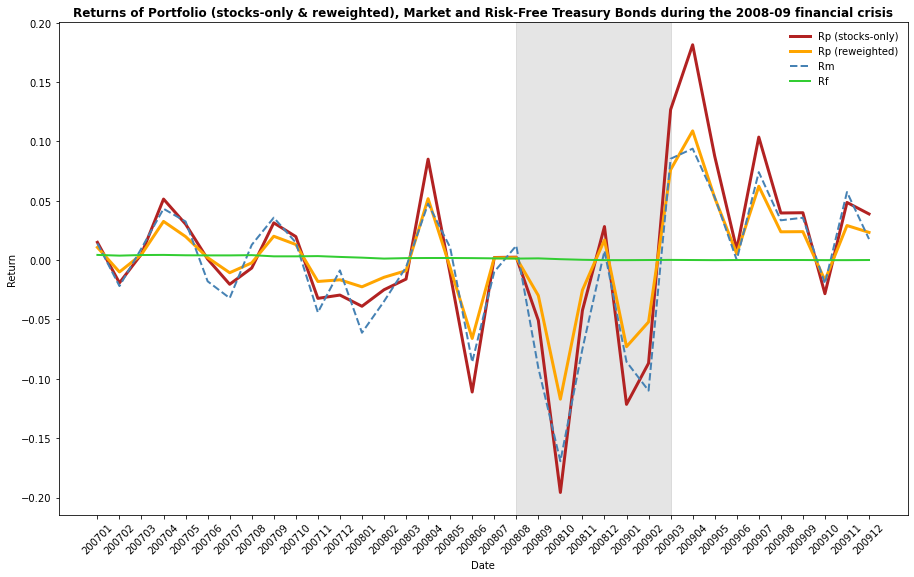

In [22]:
#a) Extended crisis period (2007-2009):

#plot return trends in the period (note: plotting returns, not excess returns):
fig = plt.figure(figsize=(1280/96, 780/96))
title = "Returns of Portfolio (stocks-only & reweighted), Market and Risk-Free Treasury Bonds during the 2008-09 financial crisis"
plt.title(title, fontsize='large', fontweight='bold')
dates = [str(date) for date in Data_FC_ext['Date'].to_list()]

#highlighting with grey background the timeframe between Aug 2008 - Mar 2009:
x1 = dates.index('200808')
x2 = dates.index('200903')
plt.axvspan(x1, x2, alpha=0.2, color='grey')

#plot:
plt.plot(dates, Data_FC_ext['Rp_adj'], color='firebrick', linewidth=3, label="Rp (stocks-only)")
plt.plot(dates, Data_FC_ext['Rp_adj_rew'], color='orange', linewidth=3, label="Rp (reweighted)")
plt.plot(dates, Data_FC_ext['Rm_adj'], color='steelblue', linewidth=2, label="Rm", ls='--')
plt.plot(dates, Data_FC_ext['Rf'], color='limegreen', linewidth=2, label="Rf")

plt.ylabel('Return')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(fontsize='medium', frameon=False)
plt.tight_layout()

plt.show()

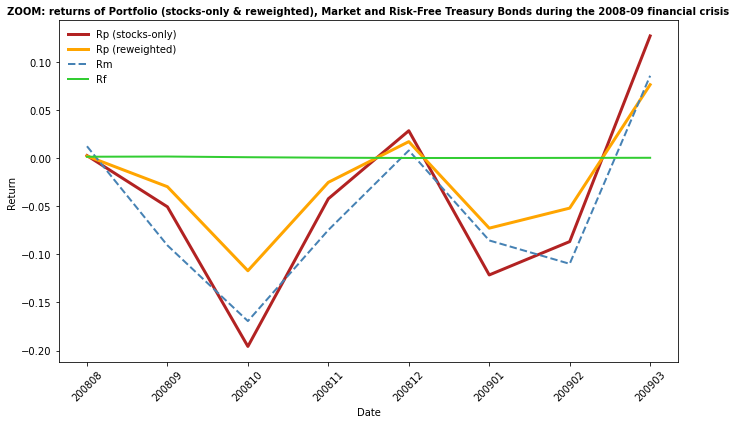

In [23]:
#b) ZOOM: Deep crisis period (Aug 2008 - Mar 2009):

#plot return trends in the period (note: plotting returns, not excess returns):
fig = plt.figure(figsize=(1024/96, 576/96))
title = "ZOOM: returns of Portfolio (stocks-only & reweighted), Market and Risk-Free Treasury Bonds during the 2008-09 financial crisis"
plt.title(title, fontsize='medium', fontweight='bold')
dates = [str(date) for date in Data_FC['Date'].to_list()]

#plot:
plt.plot(dates, Data_FC['Rp_adj'], color='firebrick', linewidth=3, label="Rp (stocks-only)")
plt.plot(dates, Data_FC['Rp_adj_rew'], color='orange', linewidth=3, label="Rp (reweighted)")
plt.plot(dates, Data_FC['Rm_adj'], color='steelblue', linewidth=2, label="Rm", ls='--')
plt.plot(dates, Data_FC['Rf'], color='limegreen', linewidth=2, label="Rf")

plt.ylabel('Return')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(fontsize='medium', frameon=False)
plt.tight_layout()

plt.show()

The two plots show clearly that the variance of the returns is much more contained for the reweighted portfolio compared to both the stocks-only portfolio and the market, thanks to the presence of less risky assets.